**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=f9f7e88b8b96f28f8867a7edb0b8f2854f9143b0caeccb01c9e861166d5e94b7
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor


You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Using cached numpy-1.20.3-cp37-cp37m-win_amd64.whl (13.6 MB)
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=1715bd8a7302328f74fee8500c9b97c09e5a5fe4dfe042cb8bf5fdadc3f1a9cf
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\84\1b\c6\aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=02a1c0a4f52e15a138242192d42256abf6cc8373cf8888592220f922962bf6e8
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\af\e9\33\04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1


You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [4]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [5]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [6]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993825,  0.01941085,  0.0378704 , ..., -0.03488844,
         0.06299514,  0.04635992],
       [ 0.00634241,  0.00814588,  0.0307194 , ..., -0.01478724,
        -0.03080929, -0.03316406],
       [ 0.0633687 , -0.02027135, -0.05077005, ..., -0.06530774,
        -0.00952994, -0.03439989],
       ...,
       [ 0.08775924,  0.03609737,  0.01263058, ..., -0.03102782,
        -0.03361679,  0.01928869],
       [ 0.05691192,  0.0538169 , -0.03995747, ..., -0.06598806,
        -0.05390476, -0.0103773 ],
       [ 0.07770479,  0.05080628,  0.02680681, ..., -0.00614124,
        -0.0131357 ,  0.02236265]], dtype=float32)

In [30]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

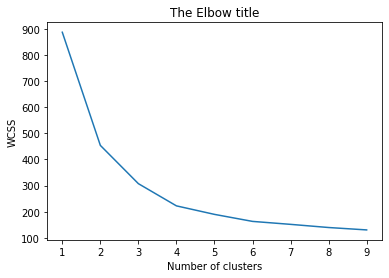

In [8]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [9]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [10]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [11]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [12]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [13]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [14]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [15]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [16]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [17]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [26]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก","หัวหิน","ราชเทวี","อเมซอน","รสชาติดี","ชาไข่มุก","ชานม","ชานมไข่มุก", "เค้าดาว"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [27]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [28]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (อร่อย, 8), (กก, 7), (กิน, 6..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."
2,2,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 11), (ทาน, 7), (อร่อย, 7), (ผม, 7), (รี..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชานมไข่มุก, 9), (ทาน, 6), (เครื่องดื่ม, 4), ..."


In [29]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 11), ('อร่อย', 8), ('กก', 7), ('กิน', 6), ('ซอย', 6), ('อาหาร', 6), ('ส้มตำ', 5), ('ทาน', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('รีวิว', 3), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5), ('เจอ', 5), ('ชั้น', 5), ('คน', 4), ('นึง', 4), ('คาเฟ่', 4), ('วัง', 4), ('แนว', 4), ('กร้าน', 4), ('แถว', 4), ('สวัสดี', 4), ('อเมซอน', 4)]

Cluster ID : 2

Most common words include : [('กิน', 11), ('ทาน', 7), ('อร่อย', 7), ('ผม', 7), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('ร้านอาหาร', 5), ('กาแฟ', 5), ('กก', 5), ('อาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('กา', 3), ('ศ', 3), ('ครั้งแรก', 3), ('ชอบ', 3), ('ซื้อ', 3), ('นะคะ', 3)]

Cluster ID : 3

Most common words include : [('ชานมไข่มุก', 9), ('ทาน', 6),

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [22]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [23]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [24]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [25]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 382), ('กิน', 339), ('ดี', 322), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273), ('(', 270), (')', 250), ('บาท', 242), ('ชอบ', 229), ('คน', 215), ("','", 215), ('ชา', 212), ('หวาน', 206), ('นั่ง', 201), ('จาน', 196)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3), ('อาหาร', 3), ('ร่างกาย', 3), ('เมล็ด', 2), ('มีรส', 2), ('หวาน', 2), ('เย็น', 2), ('ยังมี', 2), ('วิตามิน', 2), ('สีแดง', 2), ('ผลไม้', 2)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1), ('อาหาร', 1), ('เวลา', 1), ('โมง', 1), ('เย็น', 1), ('แม่ศรี', 1), ('เรือน', 1), ('โฮมโปร', 1), ('แขก', 1), ('พนักงานบริการ', 1), ('เมนู', 1)]

Cluster ID : 3

Most common w

**Step 4 - result discussion**

Step2#ดูคำที่อาจจะรวมกันแล้วมีความหมาย set new_words ใหม่เช่น
หัวหิน,ราชเทวี,อเมซอน,รสชาติดี,ชานมไข่มุก, เค้าดาว




เจอคำที่พิมพ์ซ้ำ เช่น ยากกกกก, มากกกกกก ควรจะต้องแก้ตอนทำ regex cleansing word แต่ยังหาวิธีทำไม่ทันครับ

ดูแล้ว KMEANS จัดกลุ่มได้ดูดี มีความหมายมากกว่าครับ 

1.   0 รีวิวร้านอาหาร
2.   1 รีวิวร้านกาแฟ
3.   2 รีวิวชานมไข่มุก
4.   3 รีวิวอาหารที่ร้านกาแฟ 

